In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from preprocessing import preprocessing
from rdkit import Chem
from rdkit.Chem import AllChem, RDKFingerprint


#Ensemble learning and random forest

df = preprocessing("C:\\Users\Gilbert\Documents\BCB_Research\Kcat_Benchmark_ML_Models\kcat_transferase.csv")

In [12]:
d = df.copy()

d.head()

data = d

In [13]:
# Replace '5' with the number of largest values you want to view
top_n = 30

# Use n largest values in 'Kcat' column
largest_kcat_values = data.nlargest(top_n, "Kcat")["Kcat"]

print(largest_kcat_values)

3163    78300.00000
3851    32000.00000
2141    14000.00000
2142    14000.00000
2252    14000.00000
662      8050.00000
810      7000.00000
4061     6666.66667
2748     6600.00000
937      6004.00000
3327     6000.00000
936      5694.00000
1187     5460.00000
929      5252.00000
925      5190.00000
1160     5086.00000
951      4500.00000
935      4412.00000
1181     4080.00000
811      4000.00000
934      3980.00000
3266     3869.00000
933      3595.00000
491      3580.00000
494      3580.00000
931      3453.00000
492      3450.00000
930      3324.00000
928      3217.00000
2992     3204.00000
Name: Kcat, dtype: float64


In [14]:
#preprocessing
#lets encode the data using label encoder 
label_encoder = LabelEncoder()
data["EC_number"] = label_encoder.fit_transform(data["EC_number"])
data["Species"] = label_encoder.fit_transform(data["Species"])

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
amino_to_index = {amino: i for i, amino in enumerate(amino_acids)}

# Convert amino acid sequences to one-hot encoding
def convert_to_one_hot(sequence):
    one_hot_sequence = np.zeros((len(sequence), len(amino_acids)))
    
    for i, amino in enumerate(sequence):
        if amino in amino_to_index:
            index = amino_to_index[amino]
            one_hot_sequence[i, index] = 1
            
    return one_hot_sequence.flatten()

# Apply the conversion to the DataFrame column
data["Amino"] = data["Amino_encoding"].apply(convert_to_one_hot).tolist()

# convert compound name into numbers.
compound = data["Compound"]

data["smiles"] = [Chem.MolFromSmiles(smiles) for smiles in compound]

mol = data["smiles"]

data["Fingerprint_rdk"] = [RDKFingerprint(i) for i in mol]

# Apply logarithmic transformation to 'Kcat'
data["Kcat"] = np.log1p(data["Kcat"])  # Applying log(x + 1) to handle zeros

# Normalize the target variable using Min-Max scaling
scaler = MinMaxScaler()
data["Kcat_normalized"] = scaler.fit_transform(data[["Kcat"]])


[16:11:50] WARNING: not removing hydrogen atom without neighbors
[16:11:50] WARNING: not removing hydrogen atom without neighbors


In [5]:
# data.drop(columns=["Kcat", "Compound_name", "Compound", "smiles", "Amino_encoding", "unit", "Amino"], inplace=True)

In [15]:
data.head()

,EC_number,Species,Compound,Compound_name,Amino_encoding,Kcat,unit,Amino,smiles,Fingerprint_rdk,Kcat_normalized
0,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDFLEKYYKFGSRHSAESQILKHLLKNLF...,0.040182,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x000001F12D2...,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",0.003566
1,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,0.703098,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x000001F12D2...,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",0.062396
2,0,99,C1=CC(=CN=C1)C(=O)N,Nicotinamide,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,0.079735,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x000001F12D2...,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",0.007076
3,1,39,C(CS)C(C(=O)O)N,L-Homocysteine,MGLEKKSALLEDLIEKCGGCAVVDGGFATQLEIHGAAINDPLWSAV...,0.036814,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x000001F12D2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.003267
4,1,81,C(CS)C(C(=O)O)N,L-Homocysteine,MSQNNPLRALLDKQDILLLDGAMATELEARGCNLADSLWSAKVLVE...,0.322083,s^(-1),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x000001F12D2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.028583


In [16]:
# train and split the data
# EC_number, Species, Amino, and fingerprint_rdk

from sklearn.model_selection import train_test_split

# x_fingerprint = np.array(data['Fingerprint_rdk'].tolist())

# x = x_fingerprint
# # target variable
# y = data["Kcat"]


y = np.array(data["Kcat_normalized"])
x = np.array(data["Fingerprint_rdk"].tolist())


# Ensure alignment of data
consistent_indices = np.arange(len(x))  # Assuming fingerprint and 'Kcat' data have the same length
x = x[consistent_indices]
y = y[consistent_indices]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [17]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Check data types
print("x_train data type:", type(x_train))
print("y_train data type:", type(y_train))



x_train shape: (3308, 2048)
y_train shape: (3308,)
x_train data type: <class 'numpy.ndarray'>
y_train data type: <class 'numpy.ndarray'>


In [9]:
# this initialization of the regression model
rf_regressor = RandomForestRegressor(n_estimators=125, max_depth=5, random_state=42)

rf_regressor.fit(x_train, y_train)

y_pred = rf_regressor.predict(x_test)

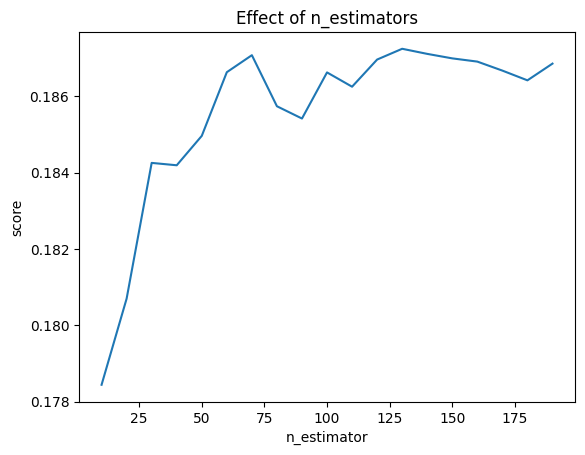

In [18]:
import matplotlib.pyplot as plt

estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    rf_regressor.set_params(n_estimators=n)
    rf_regressor.fit(x_train, y_train)
    scores.append(rf_regressor.score(x_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [20]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    # Add more hyperparameters to search
}

rf_regressor = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf_regressor, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
random_search.fit(x_train, y_train)

best_rf_regressor = random_search.best_estimator_

c:\Users\Gilbert\anaconda3\envs\bcb\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [21]:
print(best_rf_regressor)

RandomForestRegressor(max_depth=5, n_estimators=150, random_state=42)


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred)) 


MAE:  0.12863720724146158
MSE:  0.026185300532911678


In [19]:
data.describe()

,EC_number,Species,Kcat,Kcat_normalized
count,4136.000000,4136.000000,4136.000000,4136.000000
mean,237.390957,121.036267,1.872588,0.166182
std,117.585124,67.214484,2.047284,0.181685
min,0.000000,0.000000,0.000003,0.000000
25%,139.000000,81.000000,0.131028,0.011628
50%,238.000000,106.000000,1.100276,0.097643
75%,350.000000,180.000000,3.165475,0.280918
max,437.000000,265.000000,11.268316,1.000000


In [ ]:
from sklearn.model_selection import GridSearchCV

# helps finding the optimal hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    # Add more hyperparameters and values
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3)
grid_search.fit(x_train, y_train)

best_rf_regressor = grid_search.best_estimator_

In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming you have your data and target variable ready
# X_train: Input features (fingerprint_rdk)
# y_train: Target variable (kcat values)

# Calculate the mean of the target variable
mean_target = np.mean(y_train)

# Create an array of the mean target value with the same length as your data
mean_predictions = np.full_like(y_train, fill_value=mean_target)

# Calculate Mean Squared Error (MSE) for the mean prediction
mse = mean_squared_error(y_train, mean_predictions)

print("Mean Squared Error (MSE) for Mean Prediction:", mse)

Mean Squared Error (MSE) for Mean Prediction: 2549963.3355049016
